<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/5_4_3_RNN_Model_Design(Char_RNN2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

## RNN Model Design (Char-RNN)

#### **Import Module**

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
plt.rcParams['figure.figsize'] = [5, 3.5]

device = 'cuda:0'
torch.__version__, pl.__version__

('2.0.1+cu118', '2.0.3')

#### **DataSet**

##### 학습할 문장 만들기

In [ ]:
# 학습할 문장
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")
print ("FOLLOWING IS OUR TRAINING SEQUENCE:")
print (sentence)
print ("Length of 'test sentence' is %s" %len(sentence))

FOLLOWING IS OUR TRAINING SEQUENCE:
if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.
Length of 'test sentence' is 180


##### 입력 문자열과 타겟 문자 준비

In [ ]:
# make charater dictionary
char_set = list(set(sentence)) # char set 생성
char_dic = {w: i for i, w in enumerate(char_set)}
print ("CHARACTERS: ")
print (len(char_set))
print (char_set)
print ("DICTIONARY: ")
print (len(char_dic))
print (char_dic)

CHARACTERS: 
25
['k', 'a', 'l', 'h', 'f', 's', 'i', 'b', 'o', ',', 'n', '.', 'r', 'm', "'", 'u', 'c', 'e', 't', ' ', 'g', 'p', 'd', 'w', 'y']
DICTIONARY: 
25
{'k': 0, 'a': 1, 'l': 2, 'h': 3, 'f': 4, 's': 5, 'i': 6, 'b': 7, 'o': 8, ',': 9, 'n': 10, '.': 11, 'r': 12, 'm': 13, "'": 14, 'u': 15, 'c': 16, 'e': 17, 't': 18, ' ': 19, 'g': 20, 'p': 21, 'd': 22, 'w': 23, 'y': 24}


In [ ]:
data_dim    = len(char_set) # train data X:input
num_classes = len(char_set) # trian data Y:target
sequence_length = 10        # any arbitrary number
features = 1                # X,Y index
print ('data_dim : %d' %data_dim)
print ('num_classes : %d' %num_classes)

data_dim : 25
num_classes : 25


In [ ]:
dataX = []  # input sequence list
dataY = []  # target sequence list

# we will make 170 sequences
for i in range(0, len(sentence) - sequence_length):
    # 10 characters = 1 training sequence
    x_str = sentence[i : i+sequence_length]
    y_str = sentence[i+1 : i+sequence_length+1]
    # convert x, y str to index(int)
    x_idx = [char_dic[c] for c in x_str]
    y_idx = [char_dic[c] for c in y_str]
    # append to dataset list
    dataX.append(x_idx)
    dataY.append(y_idx)

    # monitoring
    if i<5:
        print ("[%3d/%3d] [%s]=>[%s]" % (i, len(sentence), x_str, y_str))
        print ("%s%s=>%s" % (' '*10, x_idx, y_idx))

[  0/180] [if you wan]=>[f you want]
          [6, 4, 19, 24, 8, 15, 19, 23, 1, 10]=>[4, 19, 24, 8, 15, 19, 23, 1, 10, 18]
[  1/180] [f you want]=>[ you want ]
          [4, 19, 24, 8, 15, 19, 23, 1, 10, 18]=>[19, 24, 8, 15, 19, 23, 1, 10, 18, 19]
[  2/180] [ you want ]=>[you want t]
          [19, 24, 8, 15, 19, 23, 1, 10, 18, 19]=>[24, 8, 15, 19, 23, 1, 10, 18, 19, 18]
[  3/180] [you want t]=>[ou want to]
          [24, 8, 15, 19, 23, 1, 10, 18, 19, 18]=>[8, 15, 19, 23, 1, 10, 18, 19, 18, 8]
[  4/180] [ou want to]=>[u want to ]
          [8, 15, 19, 23, 1, 10, 18, 19, 18, 8]=>[15, 19, 23, 1, 10, 18, 19, 18, 8, 19]


##### 입력문자 index의 list를 ndarrary로 변환

In [ ]:
X = np.array(dataX)   # ndarray(170,10)<-[170,10]
X = np.reshape(X,(X.shape[0],X.shape[1],features))
print (X.shape)       # (170,10,1)
# Target tensor 생성 # ndarray(170,10,1)<-[170,10]
Y = np.array(dataY)   # (170,10)<-[170,10]
Y = Y= np.reshape(Y,(Y.shape[0],Y.shape[1],features))
print (Y.shape)       # (170,10,1)
Y1 = np.array(dataY)[:,-1]  # 마지막 문자만, (170,)<-[170,10]
Y1= np.reshape(Y1,(Y1.shape[0],features)) # (170,1)
print (Y1.shape)      # (170,1)

(170, 10, 1)
(170, 10, 1)
(170, 1)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx]).to(device), torch.LongTensor(self.y[idx]).to(device)

In [ ]:
# trainDataset = CustomDataset(X, Y1)
# trainDataLoader = DataLoader(trainDataset, shuffle=True, drop_last=False, batch_size=1)
# trainDataset_many = CustomDataset(X, Y)
# trainDataLoader_many = DataLoader(trainDataset_many,
#                                   shuffle=True, drop_last=False, batch_size=1)

trainDataset_many2 = CustomDataset(X, Y)
trainDataLoader_many2 = DataLoader(trainDataset_many2,
                                   shuffle=False, drop_last=False, batch_size=1)

# **Model-3** : many to many + stateful

## Define

In [ ]:
hidden_dim = units = 150
batch_size = 1
direction = 1 # if bidirectional LSTM, 2

In [ ]:
class ManyToManyStatefulLSTM(pl.LightningModule):
    def __init__(self, features, units, num_classes, batch_size, batch_first=True):
        super(ManyToManyStatefulLSTM, self).__init__()
        self.lstm = nn.LSTM(features, units, batch_first=batch_first)
        self.dense = nn.Linear(units, num_classes)
        self.hn = torch.zeros(direction, batch_size, units).to(device)#(1,1,75)
        self.cn = torch.zeros(direction, batch_size, units).to(device)

    def forward(self, x):
        x = x.to(device)
        #out:(1,10,75), x:(1,10,1), hn/cn:(1,1,75)
        out, (self.hn, self.cn) = self.lstm(x, (self.hn.detach(), self.cn.detach()))
        out = self.dense(out)
        return out #(1,10,25)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        # epoch 시작할 때 hidden state와 cell state 초기화
        if batch_idx == 0:
            self.hn = torch.zeros_like(self.hn)
            self.cn = torch.zeros_like(self.cn)
        y_hat = self.to(device)(x) #(1,10,25)<-(1,10,1)
        y = y.squeeze(dim=-1)      #(1,10)<-(1,10,1)
        loss, acc = 0, 0
        for i in range(x.shape[1]): # seq.에 대한 평균 구하기
            loss += F.cross_entropy(y_hat[:, i, :], y[:, i])
            acc += FM.accuracy(y_hat[:, i, :], y[:, i],task='multiclass', num_classes=25 )

        loss /= x.shape[1]
        acc /= x.shape[1]
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)
        return loss

    def reset_state(self):
        self.hn = torch.zeros_like(self.hn)
        self.cn = torch.zeros_like(self.cn)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = ManyToManyStatefulLSTM(features, units, num_classes, batch_size).to(device)
summary(model, input_size=(batch_size, sequence_length, features))

Layer (type:depth-idx)                   Output Shape              Param #
ManyToManyStatefulLSTM                   [1, 10, 25]               --
├─LSTM: 1-1                              [1, 10, 150]              91,800
├─Linear: 1-2                            [1, 10, 25]               3,775
Total params: 95,575
Trainable params: 95,575
Non-trainable params: 0
Total mult-adds (M): 0.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.40

## Fit

In [ ]:
%%time
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='loss',
    dirpath='./aicamp/',
    filename='{epoch:02d}-{loss:.4f}',
    save_top_k=2)
trainer = pl.Trainer(max_epochs=200, callbacks=[checkpoint_callback])
trainer.fit(model, trainDataLoader_many2)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | lstm  | LSTM   | 91.8 K
1 | dense | Linear | 3.8 K 
---------------------------------
95.6 K    Trainable params
0         Non-trainable params
95.6 K    Total params
0.382     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` arg

Training: 0it [00:00, ?it/s]

CPU times: user 3min 23s, sys: 2.24 s, total: 3min 25s
Wall time: 3min 27s


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Epoch 199: 100%
170/170 [00:01<00:00, 91.35it/s, v_num=1]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
CPU times: user 6min 10s, sys: 3.33 s, total: 6min 13s
Wall time: 6min 33s

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [ ]:
log = {}
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'lightning_logs/version_{v_num}'

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

loss = [x.value for x in event_accumulator.Scalars('loss')]
acc = [x.value for x in event_accumulator.Scalars('acc')]
print(f'Max Acc:{max(acc)}')
print(f'Min Loss:{max(loss)}')

log['ManyToManyStatefulLSTM'] = [acc, loss]

plt.plot(log['ManyToManyStatefulLSTM'][0], linestyle='--', label="train_acc")
plt.plot(log['ManyToManyStatefulLSTM'][1], linestyle='--', label="train_loss")

# plt.ylim(0.1, 1)
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

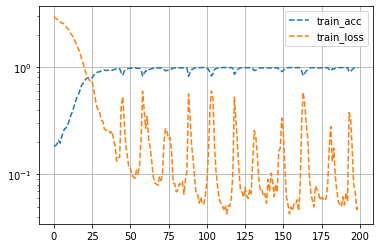

**Load Best model**

In [ ]:
#!rm -rf './aicamp/'
!ls './aicamp'
checkpoint_callback.best_model_path

'epoch=113-loss=0.0428.ckpt'  'epoch=154-loss=0.0427.ckpt'


'/content/aicamp/epoch=154-loss=0.0427.ckpt'

In [ ]:
# best_model_path
checkpoint_path = checkpoint_callback.best_model_path
# 모델 읽어오기
model = model.load_from_checkpoint(checkpoint_path, features=features,
                units=units, num_classes=num_classes, batch_size=batch_size )
model.to(device)

ManyToManyStatefulLSTM(
  (lstm): LSTM(1, 150, batch_first=True)
  (dense): Linear(in_features=150, out_features=25, bias=True)
)

**Load Pre-trained model**

In [ ]:
# # file name 수정!!
# path = "/content/aicamp/char-rnn-model3-epoch=190-loss=0.0363.ckpt"
# # 모델 읽어오기
# model = model.load_from_checkpoint(path, features=features,
#                 units=units, num_classes=num_classes, batch_size=batch_size )
# model.to(device)

## **Generate Text:** analysis

##### Generate a sequence of characters

학습문장: If you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.

In [ ]:
# 문자열 생성하기
def generate_seq2(model, char_dic, seq_length, seed_text, n_chars):
    model.reset_state()
    in_text = seed_text									# seed 문자열 + 생성 문자
    # 생성할 문자열의 수 = n_chars
    for i in range(n_chars):
        # 문자 encode : 문자 -> int
        encoded = [char_dic[char] for char in in_text]
        # 문자열 크기 조정 : max보다 크면 앞부분 제거
        encoded = encoded[-sequence_length:]
        encoded = np.array(encoded)
        encoded = np.reshape(encoded,(1,encoded.shape[0],1)) #(1,10,1) <- (1,10)

        # 다음문자 추론
        yhat = model(torch.Tensor(encoded))  ## yhat.shape=(1,10,25):확률 시퀀스
        yhat = np.argmax(yhat.cpu().detach().numpy(), axis=2) # 확률 중에서 가장 큰 값의 위치 (1,10,1)<(1,10,25)
        yhat = np.squeeze(yhat)        # (10,) <- (1,10,1)
        # 문자 디코딩 : integer -> character
        for char, index in char_dic.items():
            if index == yhat[9]:         # 시퀀스에서 마지막 값을 사용
                break
        in_text += char    # 문자열에 추가
    return in_text

In [ ]:
# test start of rhyme
print('Trigger characters: "want to bu "\nResult: \n"{}"'.format(
      generate_seq2(model, char_dic, sequence_length, 'want to bu', 200)))
# test mid-line
print('\nTrigger characters: "collect wo"\nResult: \n"{}"'.format(
      generate_seq2(model, char_dic, sequence_length, 'collect wo', 200)))
# test not in original
print('\nTrigger characters: "aabbcr than"\nResult: "{}"'.format(
      generate_seq2(model, char_dic, sequence_length, 'abbcr than', 200)))

Trigger characters: "want to bu "
Result: 
"want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the sea. the sea. the sea. the sea. "

Trigger characters: "collect wo"
Result: 
"collect woe' and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. t"

Trigger characters: "aabbcr than"
Result: "abbcr thanless immensity of the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. the sea. th"


Trigger characters: "want to bu "
Result:
"want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.to collect wood and don't assign them"

Trigger characters: "collect wo"
Result:
"collect wothem to long for the endless immensity of the sea.to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.to collect wood and don't ass"

Trigger characters: "aabbcr than"
Result: "abbcr thantdo ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.to collect wood and don't assign them t"

In [ ]:
!stop

# **Model-4** : many to many + stateful, batch_size=2

In [ ]:
# 첫번째 문장 180자
sentence1 = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea."
)
# 두번째 문장 180자
sentence2 = ("Our developer guides are deep-dives into specific topics such "
            "as layer sublassing, fine-tuning, or model saving. They're one"
            " of the best ways to become a Keras expert. Most of our ")
print ("FOLLOWING IS OUR TRAINING SEQUENCE:")
print (sentence1,sentence2)
print ("Length of 'test sentence' is %s" %len(sentence1+sentence2))

FOLLOWING IS OUR TRAINING SEQUENCE:
if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. Our developer guides are deep-dives into specific topics such as layer sublassing, fine-tuning, or model saving. They're one of the best ways to become a Keras expert. Most of our 
Length of 'test sentence' is 360


##### 입력 문자열과 타겟 문자 준비

In [ ]:
# make charater dictionary
char_set = list(set(sentence1+sentence2)) ##
char_dic = {w: i for i, w in enumerate(char_set)}
print ("CHARACTERS: ")
print (len(char_set))
print (char_set)
print ("DICTIONARY: ")
print (len(char_dic))
print (char_dic)

CHARACTERS: 
32
['c', 'w', 'K', 'e', 'T', 'g', 'n', 'v', 'l', 'x', 'd', 'y', 'r', 't', ' ', 'k', "'", 'O', 'm', 'u', 'i', 'o', '-', 'M', ',', 'a', 'b', 'f', 'p', 's', '.', 'h']
DICTIONARY: 
32
{'c': 0, 'w': 1, 'K': 2, 'e': 3, 'T': 4, 'g': 5, 'n': 6, 'v': 7, 'l': 8, 'x': 9, 'd': 10, 'y': 11, 'r': 12, 't': 13, ' ': 14, 'k': 15, "'": 16, 'O': 17, 'm': 18, 'u': 19, 'i': 20, 'o': 21, '-': 22, 'M': 23, ',': 24, 'a': 25, 'b': 26, 'f': 27, 'p': 28, 's': 29, '.': 30, 'h': 31}


In [ ]:
data_dim    = len(char_set) # train data X:input
num_classes = len(char_set) # trian data Y:target
sequence_length = 10        # any arbitrary number
features = 1                # X,Y index
print ('data_dim : %d' %data_dim)
print ('num_classes : %d' %num_classes)

data_dim : 32
num_classes : 32


In [ ]:
dataX = []  # input sequence list
dataY = []  # target sequence list

## we will make 170 x 2 sequences
for i in range(0,len(sentence1) - sequence_length): #
    ## 첫번째 문장
    # 10 characters = 1 training sequence
    x_str1 = sentence1[i : i+sequence_length]
    y_str1 = sentence1[i+1 : i+sequence_length+1]
    # convert x, y str to index(int)
    x_idx1 = [char_dic[c] for c in x_str1]
    y_idx1 = [char_dic[c] for c in y_str1]
    # append to dataset list
    dataX.append(x_idx1)
    dataY.append(y_idx1)
    ## 두번째 문장
    # 10 characters = 1 training sequence
    x_str2 = sentence2[i : i+sequence_length]
    y_str2 = sentence2[i+1 : i+sequence_length+1]
    # convert x, y str to index(int)
    x_idx2 = [char_dic[c] for c in x_str2]
    y_idx2 = [char_dic[c] for c in y_str2]
    # append to dataset list
    dataX.append(x_idx2)
    dataY.append(y_idx2)

    # monitoring
    if i<3:
        print ("[%3d/%3d] [%s]=>[%s]" % (i, len(sentence1), x_str1, y_str1))
        print ("%s%s=>%s" % (' '*10, x_idx1, y_idx1))
        print ("[%3d/%3d] [%s]=>[%s]" % (i, len(sentence2), x_str2, y_str2))
        print ("%s%s=>%s" % (' '*10, x_idx2, y_idx2))

[  0/180] [if you wan]=>[f you want]
          [20, 27, 14, 11, 21, 19, 14, 1, 25, 6]=>[27, 14, 11, 21, 19, 14, 1, 25, 6, 13]
[  0/180] [Our develo]=>[ur develop]
          [17, 19, 12, 14, 10, 3, 7, 3, 8, 21]=>[19, 12, 14, 10, 3, 7, 3, 8, 21, 28]
[  1/180] [f you want]=>[ you want ]
          [27, 14, 11, 21, 19, 14, 1, 25, 6, 13]=>[14, 11, 21, 19, 14, 1, 25, 6, 13, 14]
[  1/180] [ur develop]=>[r develope]
          [19, 12, 14, 10, 3, 7, 3, 8, 21, 28]=>[12, 14, 10, 3, 7, 3, 8, 21, 28, 3]
[  2/180] [ you want ]=>[you want t]
          [14, 11, 21, 19, 14, 1, 25, 6, 13, 14]=>[11, 21, 19, 14, 1, 25, 6, 13, 14, 13]
[  2/180] [r develope]=>[ developer]
          [12, 14, 10, 3, 7, 3, 8, 21, 28, 3]=>[14, 10, 3, 7, 3, 8, 21, 28, 3, 12]


##### 입력문자 index의 list를 ndarrary로 변환

In [ ]:
# input tensor 생성 # ndarray(340,10,1)<-[340,10]
X = np.array(dataX)
X = np.reshape(X,(X.shape[0],X.shape[1],features))
print (X.shape)
# Target tensor 생성 # ndarray(170,10,1)<-[170,10]
y = np.array(dataY)
y = np.reshape(y,(y.shape[0],y.shape[1],features))
print (y.shape)

(340, 10, 1)
(340, 10, 1)


##### Define

In [ ]:
# many to many + stateful + batch_size=2
hidden_dim = units = 300 # 75
batch_size = 2
direction = 1 # if bidirectional LSTM, 2

class ManyToManyStatefulLSTM2(pl.LightningModule):
    def __init__(self, features, units, num_classes, batch_size, batch_first=True):
        super(ManyToManyStatefulLSTM2, self).__init__()
        self.lstm = nn.LSTM(features, units, batch_first=batch_first)
        self.dense = nn.Linear(units, num_classes)
        self.hn = torch.zeros(direction, batch_size, units).to(device)#(1,2,75)
        self.cn = torch.zeros(direction, batch_size, units).to(device)

    def forward(self, x):
        x = x.to(device) #(2,10,1)
        #out:(2,10,150), x:(2,10,1), hn/cn:(2,1,150)
        out, (self.hn, self.cn) = self.lstm(x, (self.hn.detach(), self.cn.detach()))
        out = self.dense(out) #(2,10,32)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        # 배치를 시작할 때 hidden state와 cell state를 초기화 한다.
        if batch_idx == 0:
            self.hn = torch.zeros_like(self.hn)
            self.cn = torch.zeros_like(self.cn)
        y_hat = self.to(device)(x) #(2,10,32)
        y = y.squeeze(dim=-1) #(2,10)
        loss, acc = 0, 0
        for i in range(x.shape[1]):
            loss += F.cross_entropy(y_hat[:, i, :], y[:, i])
            acc += FM.accuracy(y_hat[:, i, :], y[:, i],task='multiclass',num_classes=num_classes )
        loss /= x.shape[1]
        acc /= x.shape[1]
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)
        return loss

    def reset_state(self):
        self.hn = torch.zeros_like(self.hn)
        self.cn = torch.zeros_like(self.cn)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = ManyToManyStatefulLSTM2(features, hidden_dim, num_classes, batch_size).to(device)
summary(model, input_size=(batch_size, sequence_length, features))

Layer (type:depth-idx)                   Output Shape              Param #
ManyToManyStatefulLSTM2                  [2, 10, 32]               --
├─LSTM: 1-1                              [2, 10, 300]              363,600
├─Linear: 1-2                            [2, 10, 32]               9,632
Total params: 373,232
Trainable params: 373,232
Non-trainable params: 0
Total mult-adds (M): 7.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 1.49
Estimated Total Size (MB): 1.55

##### Compile

##### Fit

In [ ]:
trainDataset_many3 = CustomDataset(X, y)
trainDataLoader_many3 = DataLoader(trainDataset_many3,
                                  shuffle=False, drop_last=False, batch_size=2)

In [ ]:
# seq : [(2,10,1),(2,10,1)] = [x, y]
seq = next(iter(trainDataLoader_many3))
seq_x,seq_y = seq # (2,10,1),(2,10,1)
ps(seq_x)#seq X:(2,10,1)
ps(seq_y)#seq Y:(2,10,1)

[] Shapetorch.Size([2, 10, 1])
[] Shapetorch.Size([2, 10, 1])


In [ ]:
%%time
model = ManyToManyStatefulLSTM2(features, hidden_dim, num_classes, batch_size).to(device)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='loss',
    dirpath='./aicamp/',
    filename='{epoch:02d}-{loss:.4f}',
    save_top_k=2)
trainer = pl.Trainer(max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(model, trainDataLoader_many3)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | lstm  | LSTM   | 363 K 
1 | dense | Linear | 9.6 K 
---------------------------------
373 K     Trainable params
0         Non-trainable params
373 K     Total params
1.493     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


CPU times: user 13min 1s, sys: 6.8 s, total: 13min 8s
Wall time: 13min 20s


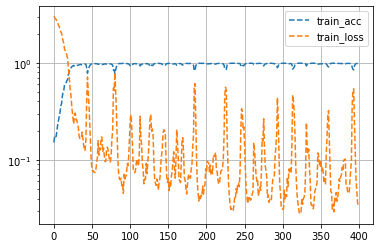

In [ ]:
log = {}
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'lightning_logs/version_{v_num}'

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

steps = {x.step for x in event_accumulator.Scalars("epoch")}
train_acc = [x.value for x in event_accumulator.Scalars('acc') if x.step in steps]
train_loss = [x.value for x in event_accumulator.Scalars('loss') if x.step in steps]

log['ManyToManyStatefulLSTM'] = [train_acc, train_loss]

plt.plot(log['ManyToManyStatefulLSTM'][0], linestyle='--', label="train_acc")
plt.plot(log['ManyToManyStatefulLSTM'][1], linestyle='--', label="train_loss")

# plt.ylim(0.1, 1)
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

In [ ]:
#!rm -rf './aicamp/'
!ls './aicamp'
checkpoint_callback.best_model_path

'epoch=342-loss=0.0058.ckpt'  'epoch=344-loss=0.0055.ckpt'


'/content/aicamp/epoch=344-loss=0.0055.ckpt'

In [ ]:
# best_model_path
checkpoint_path = checkpoint_callback.best_model_path
# 모델 읽어오기
model = model.load_from_checkpoint(checkpoint_path, features=features,
                units=hidden_dim, num_classes=num_classes, batch_size=batch_size )
model.to(device)

ManyToManyStatefulLSTM2(
  (lstm): LSTM(1, 300, batch_first=True)
  (dense): Linear(in_features=300, out_features=32, bias=True)
)

**Load Pre-trained model**

In [ ]:
# # file name 수정!!
# path = "/content/aicamp/char-rnn-model3-epoch=190-loss=0.0363.ckpt"
# # 모델 읽어오기
# model = model.load_from_checkpoint(path, features=features,
#                 units=units, num_classes=num_classes, batch_size=batch_size )
# model.to(device)

#### **Generate Text:** analysis

##### Define generate_seq function

- 10개의 출력 시퀀스를 받으므로 수정

In [ ]:
# 문자열 생성하기
def generate_seq3(model, char_dic, seq_length, seed_text, n_chars):
    model.reset_state()
    in_text1 = seed_text									# seed 문자열 + 생성 문자
    in_text2 = seed_text									# seed 문자열 + 생성 문자
    # 생성할 문자열의 수 = n_chars
    for i in range(n_chars):
        # 문자 encode : 문자 -> int
        encoded1 = [char_dic[char] for char in in_text1]  ## 두개의 시퀀스 준비
        encoded2 = [char_dic[char] for char in in_text2]  ##
        # 문자열 크기 조정 : max보다 크면 앞부분 제거
        encoded1 = np.array(encoded1[-sequence_length:])
        encoded2 = np.array(encoded2[-sequence_length:])
        encoded3 = np.array([encoded1,encoded2])                 ##(2,1,10) < (1,10)*2
        encoded3 = np.reshape(encoded3,(2,encoded2.shape[-1],1)) ##(2,10,1) <- (2,1,10)
        # 다음문자 추론
        yhat = model(torch.FloatTensor(encoded3))  ## yhat.shape=(2,10,32):확률 시퀀스
        yhat = yhat.cpu().detach().numpy()
        yhat1 = np.argmax(yhat[0], axis=1) ## 첫 추론값을 index로 변환  (10,)<(2,10,32)
        yhat2 = np.argmax(yhat[1], axis=1) ## 두번째 추론값을 index로 변환  (10,)<(2,10,32)
        # 문자 디코딩 : integer -> character
        for char, index in char_dic.items():
            if index == yhat1[9]:         # 시퀀스에서 마지막 값을 사용
                break
        in_text1 += char    # 문자열에 추가
        for char, index in char_dic.items():
            if index == yhat2[9]:         # 시퀀스에서 마지막 값을 사용
                break
        in_text2 += char    # 문자열에 추가
    return (in_text1,in_text2)

##### Generate a sequence of characters

학습문장: if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.

In [ ]:
# test start of rhyme
r1,r2 = generate_seq3(model, char_dic, sequence_length, 'want to bu', 200)
print('Trigger characters: "want to bu "\nResult1: \n"{}"\nResult2: \n"{}\n"'.format(r1,r2))
# test mid-line
r1,r2 = generate_seq3(model, char_dic, sequence_length, 'collect wo', 200)
print('Trigger characters: "collect wo "\nResult1: \n"{}"\nResult2: \n"{}\n"'.format(r1,r2))
# test not in original
r1,r2 = generate_seq3(model, char_dic, sequence_length, 'abbcr than', 200)
print('Trigger characters: "abbcr than "\nResult1: \n"{}"\nResult2: \n"{}"'.format(r1,r2))

Trigger characters: "want to bu "
Result1: 
"want to buald a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to become a Keras expe"
Result2: 
"want to buald a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to become a Keras expe
"
Trigger characters: "collect wo "
Result1: 
"collect wof uoole sodeo build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to bec"
Result2: 
"collect wof uoole sodeo build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to bec
"
Trigger characters: "abbcr than "
Resu

Trigger characters: "want to bu "
Result1:
"want to buald a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to become a Keras expe"
Result2:
"want to buald a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to become a Keras expe
"
Trigger characters: "collect wo "
Result1:
"collect wof uoole sodeo build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to bec"
Result2:
"collect wof uoole sodeo build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to bec
"
Trigger characters: "abbcr than "
Result1:
"abbcr than for the endless immensity of the sea. them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to become a Keras expert. Most of our of otog uh assch the"
Result2:
"abbcr than for the endless immensity of the sea. them tasks and work, but rather teach them to long for the endless immensity of the sea. the bess ways to become a Keras expert. Most of our of otog uh assch the"

#### **실습과제**

##### 과제 1. model-1,2에서 fit(batch_size=)를 32로 바꾸고 loss 함수의 모습을 확인하자
###### -- 변화의 원인을 검토해 보자.
##### 과제 2. 문장의 끝부분을 학습하는데 문제가 있다.
###### -- 문제점을 찾아 개선 방법을 적용해 보고 결과를 확인하자.
##### 과제 3. 학습문장을 Keras Documents에서 2000자 정도 가져다 넣어서 실행해 보자('.'뒤에'\n'도 넣어주자)
###### -- 모델을 개선 하자(hidden_dim, layer추가), batch_size, epoch를 바꿔보자
###### -- 문장이 길어졌을때 statful을 사용하는 것이 유의미 한지 확인해 보자

In [ ]:
# 학습할 문장
sentence = (
"About Keras\nKeras is a deep learning API written in Python, "
"running on top of the machine learning platform TensorFlow. It"
" was developed with a focus on enabling fast experimentation. "
"Being able to go from idea to result as fast as possible is key"
" to doing good research.\n\nKeras & TensorFlow 2.0\nTensorFlow"
" 2.0 is an end-to-end, open-source machine learning platform. "
"You can think of it as an infrastructure layer for differentiable"
" programming. It combines four key abilities:\n"
"Efficiently executing low-level tensor operations on CPU, GPU, or TPU.\n"
"Computing the gradient of arbitrary differentiable expressions.\n"
"Scaling computation to many devices (e.g. the Summit supercomputer"
" at Oak Ridge National Lab, which spans 27,000 GPUs).\nExporting "
"programs (\"graphs\") to external runtimes such as servers, browsers, "
"mobile and embedded devices.\nKeras is the high-level API of "
"TensorFlow 2.0: an approchable, highly-productive interface for "
"solving machine learning problems, with a focus on modern deep "
"learning. It provides essential abstractions and building blocks "
"for developing and shipping machine learning solutions with high "
"iteration velocity.\nKeras empowers engineers and researchers to "
"take full advantage of the scalability and cross-platform capabilities "
"of TensorFlow 2.0: you can run Keras on TPU or on large clusters of "
"GPUs, and you can export your Keras models to run in the browser or "
"on a mobile device.\n\nFirst contact with Keras\nThe core data"
"structures of Keras are layers and models. The simplest type of "
"model is the Sequential model, a linear stack of layers. For more "
"complex architectures, you should use the Keras functional API, which "
"allows to build arbitrary graphs of layers, or write models entirely "
"from scratch via subclasssing.\nThe Keras ecosystem\nThe Keras "
"project isn't limited to the core Keras API for building and "
"training neural networks. It spans a wide range of related "
"initiatives that cover every step of the machine learning workflow."
"\n\nKeras Tuner\nKeras Tuner Documentation - Keras Tuner GitHub repository"
"\nKeras Tuner is an easy-to-use, scalable hyperparameter optimization "
"framework that solves the pain points of hyperparameter search. Easily "
"configure your search space with a define-by-run syntax, then leverage "
"one of the available search algorithms to find the best hyperparameter "
"values for your models. Keras Tuner comes with Bayesian Optimization, "
"Hyperband, and Random Search algorithms built-in, and is also designed "
"to be easy for researchers to extend in order to experiment with new "
"search algorithms.\n\nAutoKeras\nAutoKeras Documentation - AutoKeras "
"GitHub repository\n\nAutoKeras is an AutoML system based on Keras. "
"It is developed by DATA Lab at Texas A&M University. The goal of AutoKeras"
" is to make machine learning accessible for everyone. It provides "
"high-level end-to-end APIs such as ImageClassifier or TextClassifier "
"to solve machine learning problems in a few lines, as well as flexible "
"building blocks to perform architecture search."
)
print ("FOLLOWING IS OUR TRAINING SEQUENCE:")
print (sentence)
print ("Length of 'test sentence' is %s" %len(sentence))